In [1]:
!pip install --upgrade keras_applications==1.0.6 keras==2.2.4

Requirement already up-to-date: keras_applications==1.0.6 in /opt/conda/envs/python36_tf/lib/python3.6/site-packages
Requirement already up-to-date: keras==2.2.4 in /opt/conda/envs/python36_tf/lib/python3.6/site-packages
Requirement already up-to-date: numpy>=1.9.1 in /opt/conda/envs/python36_tf/lib/python3.6/site-packages (from keras_applications==1.0.6)
Requirement already up-to-date: h5py in /opt/conda/envs/python36_tf/lib/python3.6/site-packages (from keras_applications==1.0.6)
Requirement already up-to-date: six>=1.9.0 in /home/jovyan/modelarts-sdk (from keras==2.2.4)
Requirement already up-to-date: keras-preprocessing>=1.0.5 in /opt/conda/envs/python36_tf/lib/python3.6/site-packages (from keras==2.2.4)
Requirement already up-to-date: pyyaml in /opt/conda/envs/python36_tf/lib/python3.6/site-packages (from keras==2.2.4)
Requirement already up-to-date: scipy>=0.14 in /opt/conda/envs/python36_tf/lib/python3.6/site-packages (from keras==2.2.4)
You are using pip version 9.0.1, however 

In [2]:
import os
if os.path.exists('./data') == False:
    from modelarts.session import Session
    session = Session()

    session.download_data(
        bucket_path="modelarts-labs/end2end/image_recognition/dog_and_cat_25000.tar.gz",
        path="./dog_and_cat_25000.tar.gz")

    # 使用tar命令解压资源包
    !tar xf ./dog_and_cat_25000.tar.gz

    # 清理压缩包
    !rm -f ./dog_and_cat_25000.tar.gz

In [3]:
!mkdir model

mkdir: cannot create directory ‘model’: File exists


In [4]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
import numpy as np

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.
/opt/conda/envs/python36_tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/python36_tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/python36_tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/python36_tf/lib/python3.6

In [5]:
import os
from PIL import Image
def load_data():
    dirname = "./data"
    path = "./data"

    num_train_samples = 25000

    x_train = np.empty((num_train_samples, 224,224,3), dtype='uint8')
    y_train = np.empty((num_train_samples,1), dtype='uint8')
    index = 0
    for file in os.listdir("./data"):
        image = Image.open(os.path.join(dirname,file)).resize((224,224))
        image = np.array(image)
        x_train[index,:,:,:] = image

        if "cat" in file:
            y_train[index,0] =1
        elif "dog" in file:
            y_train[index,0] =0

        index += 1
    return (x_train, y_train)

In [6]:
(x_train, y_train) = load_data()

In [7]:
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 1)


In [8]:
from keras.utils import np_utils
def process_data(x_train,y_train):
    x_train = x_train.astype(np.float32)
    x_train /= 255
    n_classes = 2
    y_train = np_utils.to_categorical(y_train, n_classes)
    return x_train,y_train

In [9]:
x_train,y_train= process_data(x_train,y_train)
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 2)


In [10]:
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    print(type(model))
    return model

In [11]:
base_model = VGG16(weights=None, include_top=False)

In [12]:
model = build_model(base_model)
model.summary()

<class 'keras.engine.training.Model'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, No

In [13]:
import keras 
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [14]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import math
es = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath="./model/ckp_vgg16_dog_and_cat.h5", monitor="val_acc", verbose=1, save_best_only=True, mode="auto", period=1)

#lr = ReduceLROnPlateau(monitor="val_acc", factor=0.1, patience=3, verbose=1, mode="auto", min_lr=0)
epochs = 10 #总的循环次数

def step_decay(epoch):
    base_lrate = 0.1     #初始学习率
    lrate = 0.0001
    if mode is 'power_decay':
        decay_rate = 0.8    #衰减率 
        lrate = base_lrate * ((1 - math.float(epoch) / epochs) ** decay_rate)
    if mode is 'linear_decay':  #线性衰减 
        decay_rate = 0.98    #衰减率 
        lrate = 1/(1 + decay_rate * epoch) * base_lrate
    if mode is 'exponent_decay':  #指数衰减
        decay_rate = 0.2    #衰减率
        lrate = base_lrate * math.pow(decay_rate, (epoch + 1)/epochs)
    if mode is 'cos_decay': #余弦衰减
        min_lrate = 0.001
        lrate = 0.5 * (base_lrate - min_lrate) * (1 + math.cos( epoch/epochs * 3.14 )) 
    return lrate
mode = 'linear_decay'
lr = LearningRateScheduler(step_decay, 1) 
#https://m.w3cschool.cn/tensorflow_python/tf_keras_callbacks_LearningRateScheduler.html

callbacks = [es,cp,lr]

In [14]:
history = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=16, 
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
18750/18750 [==============================] - 166s 9ms/step - loss: 0.6939 - acc: 0.4987 - val_loss: 0.6947 - val_acc: 0.5019

Epoch 00001: val_acc improved from -inf to 0.50192, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.05050505050505051.
18750/18750 [==============================] - 161s 9ms/step - loss: 0.6904 - acc: 0.5284 - val_loss: 0.6922 - val_acc: 0.5389

Epoch 00002: val_acc improved from 0.50192 to 0.53888, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.033783783783783786.
18750/18750 [==============================] - 161s 9ms/step - loss: 0.6882 - acc: 0.5404 - val_loss: 0.6651 - val_acc: 0.5901

Epoch 00003: val_acc improved from 0.53888 to 0.59008, saving model to ./model/ckp_vgg16_dog_and_c

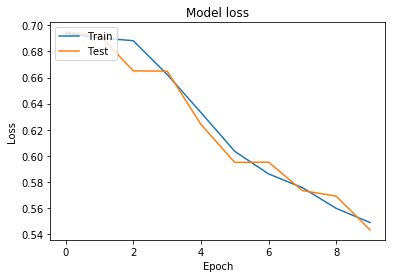

In [16]:
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

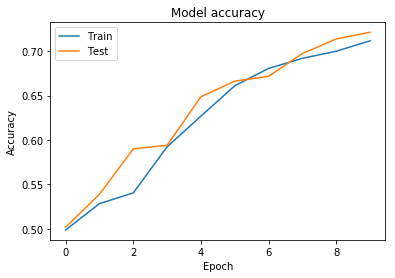

In [17]:
# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
mode = 'exponent_decay'
lr = LearningRateScheduler(step_decay, 1) 
callbacks = [es,cp,lr]

In [16]:
history = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=16, 
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.08513399225207846.
18750/18750 [==============================] - 171s 9ms/step - loss: 0.6934 - acc: 0.5095 - val_loss: 0.6928 - val_acc: 0.4981

Epoch 00001: val_acc improved from -inf to 0.49808, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.07247796636776956.
18750/18750 [==============================] - 161s 9ms/step - loss: 0.6920 - acc: 0.5132 - val_loss: 0.6932 - val_acc: 0.5021

Epoch 00002: val_acc improved from 0.49808 to 0.50208, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.061703386272000976.
18750/18750 [==============================] - 164s 9ms/step - loss: 0.6904 - acc: 0.5308 - val_loss: 0.6683 - val_acc: 0.5992

Epoch 00003: val_acc improved from 0.50208 to 0.59920, saving model to ./model/ckp

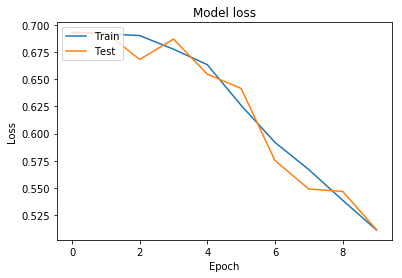

In [24]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

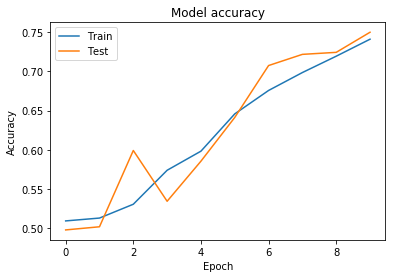

In [25]:
# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [26]:
mode = 'cos_decay'
lr = LearningRateScheduler(step_decay, 1) 
callbacks = [es,cp,lr]

In [27]:
history = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=16, 
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/10

Epoch 00001: LearningRateScheduler setting learning rate to 0.099.
18750/18750 [==============================] - 161s 9ms/step - loss: 0.5480 - acc: 0.7177 - val_loss: 0.4949 - val_acc: 0.7528

Epoch 00001: val_acc improved from 0.74976 to 0.75280, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler setting learning rate to 0.096579733136807.
18750/18750 [==============================] - 161s 9ms/step - loss: 0.4740 - acc: 0.7707 - val_loss: 0.4618 - val_acc: 0.7787

Epoch 00002: val_acc improved from 0.75280 to 0.77872, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler setting learning rate to 0.0895556069589076.
18750/18750 [==============================] - 162s 9ms/step - loss: 0.4092 - acc: 0.8099 - val_loss: 0.3744 - val_acc: 0.8310

Epoch 00003: val_acc improved from 0.77872 to 0.83104, saving model to ./model/ckp_vgg16_dog_and_

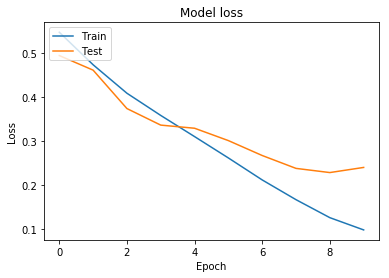

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

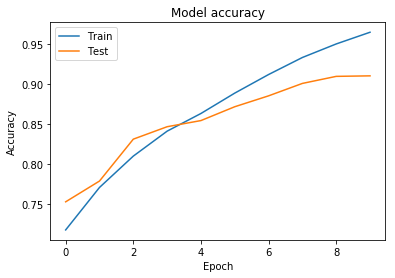

In [29]:
# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()